# Predicting Continuous Target Variables with Regression Analysis

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', header=None, sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


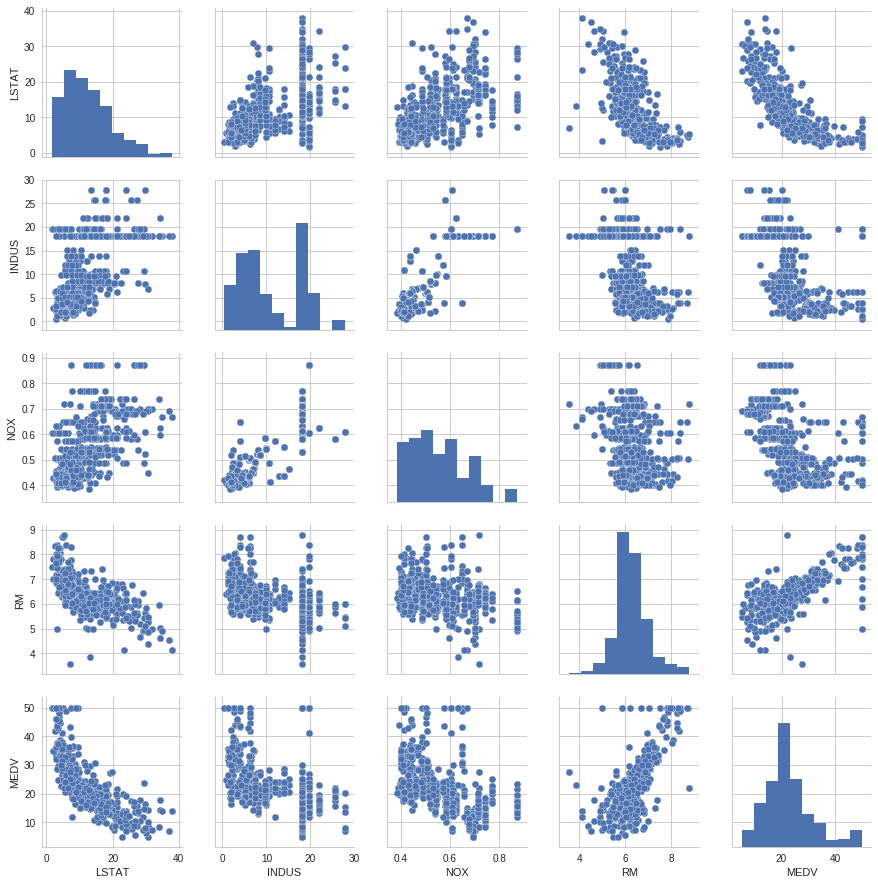

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
#cols = df.columns
sns.pairplot(df[cols], size=2.5)
plt.show()

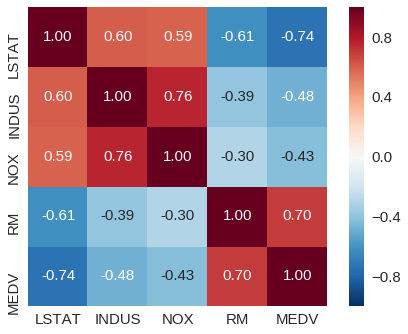

In [4]:
import numpy as np
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 15}, 
                 yticklabels=cols, xticklabels=cols)
plt.show()

## Implementing an ordinary least squares linear regression model

In [5]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1]).reshape(-1, 1)
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X).reshape(-1, 1)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [6]:
X = df['RM'].values.reshape(-1, 1)
y = df['MEDV'].values.reshape(-1, 1)

from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

lr = LinearRegressionGD(eta=10**-3, n_iter=100)
lr.fit(X_std, y_std)

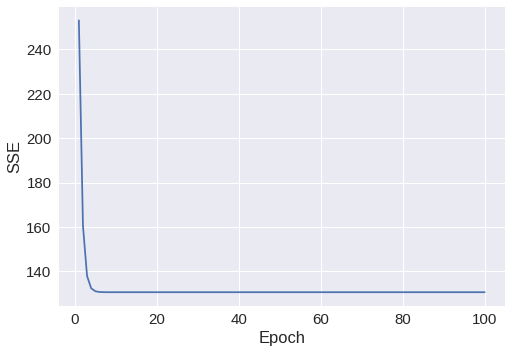

In [7]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [8]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='blue')
    plt.plot(X, model.predict(X), color='red')
    return None

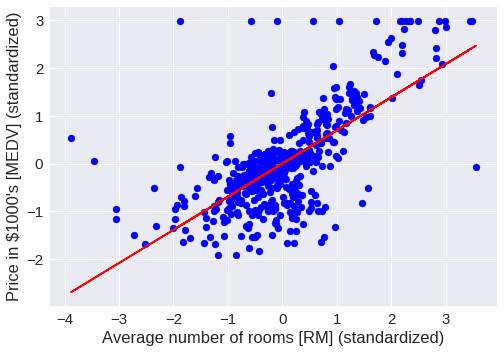

In [9]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.show()

In [10]:
num_rooms_std = sc_x.transform([[5.0]])
price_std = lr.predict(num_rooms_std)
print("Price in $1000's: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000's: 10.840


In [11]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


## Estimating the coeffcient of a regression model via scikit-learn

In [12]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


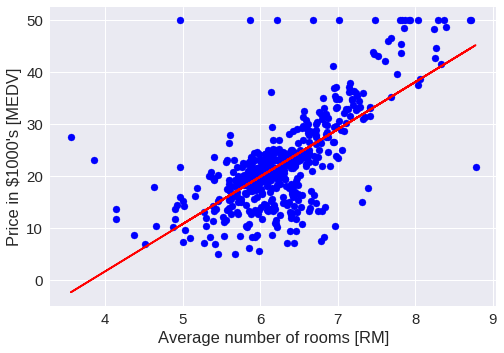

In [13]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

## Fitting a robust regression model using RANSAC

In [14]:
from sklearn.linear_model import RANSACRegressor
ransac = RANSACRegressor(LinearRegression(), max_trials=100, 
                         min_samples=50, loss=lambda x, y: np.abs(np.array(x)-np.array(y)).reshape(1, -1)[0], 
                         residual_threshold=5.0, random_state=0)
ransac.fit(X, y)

RANSACRegressor(base_estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
        is_data_valid=None, is_model_valid=None,
        loss=<function <lambda> at 0x7ffa0889d378>, max_trials=100,
        min_samples=50, random_state=0, residual_metric=None,
        residual_threshold=5.0, stop_n_inliers=inf, stop_probability=0.99,
        stop_score=inf)

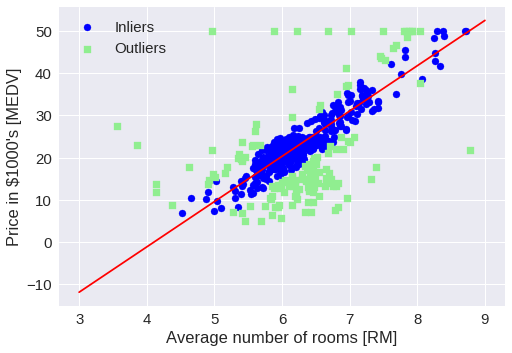

In [15]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask], c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], c='lightgreen', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper left')
plt.show()

In [16]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.735
Intercept: -44.089


## Evaluating the performance of linear regression models

In [17]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

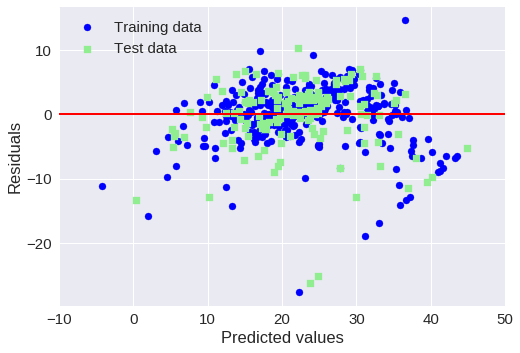

In [18]:
plt.scatter(y_train_pred, y_train_pred - y_train, 
            c='blue', marker='o', label='Training data')
plt.scatter(y_test_pred, y_test_pred - y_test, 
            c='lightgreen', marker='s', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error
print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196


In [20]:
from sklearn.metrics import r2_score
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred), 
                                       r2_score(y_test, y_test_pred)))

R^2 train: 0.765, test: 0.673


In [21]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)
from sklearn.linear_model import ElasticNet
enet = ElasticNet(alpha=1, l1_ratio=0.5)
linear = LinearRegression()

In [22]:
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)
enet.fit(X_train, y_train)
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
print('Ridge R2: %.3f' % (ridge.score(X_test, y_test)))
print('Lasso R2: %.3f' % (lasso.score(X_test, y_test)))
print('Elastic Net R2: %.3f' % (enet.score(X_test, y_test)))
print('Simple Linear Net R2: %.3f' % (linear.score(X_test, y_test)))

Ridge R2: 0.667
Lasso R2: 0.612
Elastic Net R2: 0.617
Simple Linear Net R2: 0.673


## Turning a linear regression model into a curve – polynomial regression

In [24]:
from sklearn.preprocessing import PolynomialFeatures
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 
              586.0])[:, np.newaxis]
y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2,
              360.8, 368.0, 391.2,
              390.8])
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [25]:
lr.fit(X, y)
X_fit = np.arange(250,600,10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

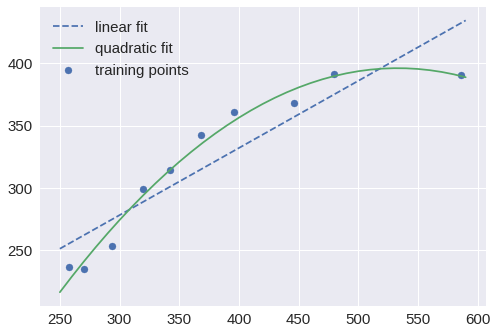

In [26]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, 
         label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, 
         label='quadratic fit')
plt.legend(loc='upper left')
plt.show()

In [27]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (mean_squared_error(y, y_lin_pred),
                                                      mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (r2_score(y, y_lin_pred),
                                                      r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


## Modeling nonlinear relationships in the Housing Dataset

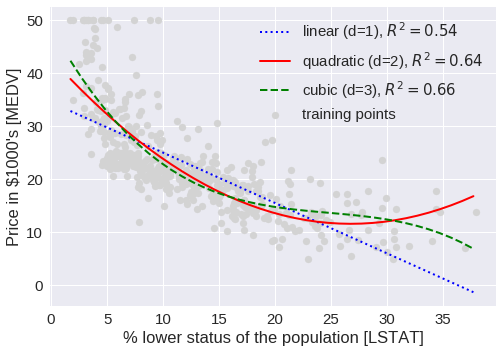

In [28]:
X = df[['LSTAT']].values
y = df['MEDV'].values
regr = LinearRegression()

# create polynomial features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# linear fit
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]
regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# quadratic fit
regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# cubic fit
regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y, label='training points', color='lightgray')
plt.plot(X_fit, y_lin_fit,label='linear (d=1), $R^2=%.2f$' % linear_r2,
         color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2, 
         color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label='cubic (d=3), $R^2=%.2f$' % cubic_r2, 
         color='green', lw=2, linestyle='--')
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')
plt.show()

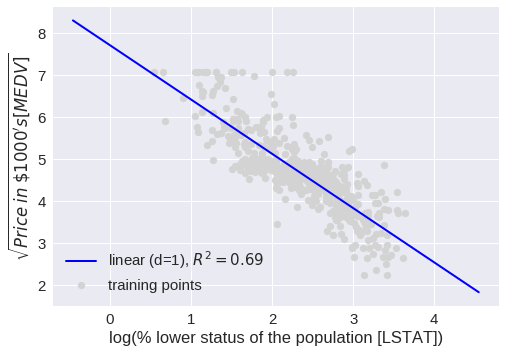

In [29]:
# transform features
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# fit features
X_fit = np.arange(X_log.min()-1, 
                  X_log.max()+1, 1)[:, np.newaxis]
regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# plot results
plt.scatter(X_log, y_sqrt, 
            label='training points', 
            color='lightgray')
plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', lw=2)
plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000\'s [MEDV]}$')
plt.legend(loc='lower left')
plt.show()

## Dealing with nonlinear relationships using random forests

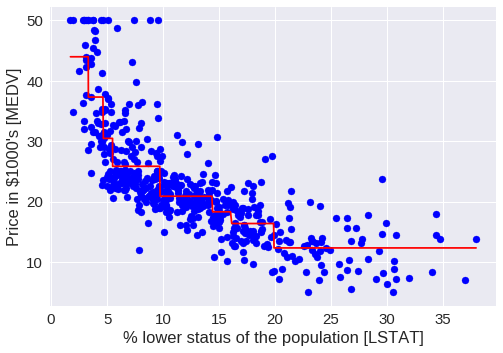

In [30]:
from sklearn.tree import DecisionTreeRegressor
X = df[['LSTAT']].values
y = df['MEDV'].values
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

In [31]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.4, random_state=1)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (mean_squared_error(y_train, y_train_pred),
                                       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

MSE train: 1.642, test: 11.052
R^2 train: 0.979, test: 0.878


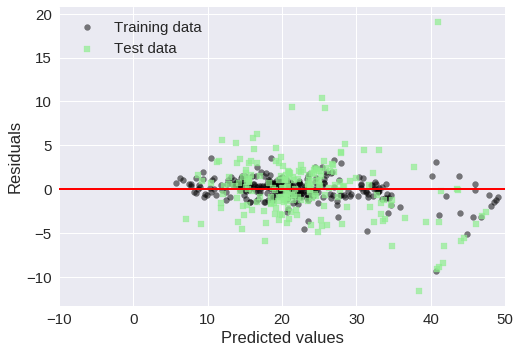

In [32]:
plt.scatter(y_train_pred,
            y_train_pred - y_train,
            c='black',
            marker='o',
            s=35,
            alpha=0.5,
            label='Training data')
plt.scatter(y_test_pred,
            y_test_pred - y_test,
            c='lightgreen',
            marker='s',
            s=35,
            alpha=0.7,
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.show()